# First Look at DP

Differential privacy (DP) is a technique used to release information about a population
in a way that limits the exposure of any one individual's personal information.

In this notebook, we'll conduct a differentially-private analysis on a teacher survey (a tabular dataset).

The raw data consists of survey responses from teachers in primary and secondary schools in an unspecified U.S. state.

## Why Differential Privacy?

Protecting the privacy of individuals while sharing information is nontrivial.
Let's say I naively "anonymized" the teacher survey by removing the person's name.

In [1]:
import pandas as pd
df = pd.read_csv("../data/teacher_survey/teacher_survey.csv")
df.columns = ['name',
              'sex',
              'age',
              'maritalStatus',
              'hasChildren',
              'highestEducationLevel',
              'sourceOfStress',
              'smoker',
              'optimism',
              'lifeSatisfaction',
              'selfEsteem']

# naively "anonymize" by removing the name column
del df["name"]

It would still be very easy to re-identify individuals via quasi-identifiers.
Say I was curious about my non-binary co-worker Chris, and I knew their age (27).

In [2]:
chris = df.loc[(df['sex'] == 3) & (df['age'] == 27)]
chris[["sex", "age", "maritalStatus", "smoker"]] # print a few columns of interest

,sex,age,maritalStatus,smoker
2251,3,27,3,1


In a dataset of 7,000 records, these two identifiers alone uniquely identified my coworker, allowing me to see their responses— they are unmarried, but living with their partner. 
In addition I can also see that they are a smoker.

In other situations there are more nuanced techniques that can be used to determine if an individual exists in a dataset (called a membership attack)
or reconstruct parts of, or even the entire dataset, from summary statistics.

Giving strong formal privacy guarantees requires the rigorous mathematical grounding that differential privacy provides.

## Steps of a DP Analysis

A differentially private analysis is usually conducted in the following steps:

1. Identify the unit of privacy
2. Consider privacy risk 
3. Collect public information
4. Construct a measurement
5. Make a DP release

It is common to return to prior steps to make further releases.


### 1. Identify the Unit of Privacy
We first need to isolate exactly what we're protecting.

In the teacher survey, the unit of privacy is the addition or removal of one teacher. 
Since each teacher contributes at most one row to the dataset, 
the unit of privacy corresponds to defining the maximum number of row contributions to be one.

In [3]:
max_contributions = 1

We will use this bound to tune our methods such that data releases are quantifiably indistinguishable 
upon the addition or removal of any one teacher from any input dataset.

Broadly speaking, differential privacy can be applied to any medium of data for which you can define a unit of privacy.
In other contexts, the unit of privacy may correspond to multiple rows, a user ID, or nodes or edges in a graph.

The unit of privacy may also be more general or more precise than a single individual.
In the data analysis conducted in this notebook, we'll refer to an individual and the unit of privacy interchangeably, 
because in this example we've defined the unit of privacy to be one individual. 

### 2. Consider Privacy Risk
The next step is to consider the risk of disclosing information about your sensitive dataset.

If the dataset is available to the public, then differentially private methods are not necessary.
Whereas, if the dataset could place individuals at severe risk of harm, then you should reconsider making any data release at all.
Differentially private methods are used to make releases on data with a risk profile somewhere between these two extremes.

The level of privacy afforded to individuals in a dataset under analysis is quantified by _privacy parameters_.
One such privacy parameter is epsilon ($\epsilon$), a non-negative number, where larger values afford less privacy.
$\epsilon$ can be viewed as a proxy to quantify the worst-case risk to any individual.
It is customary to refer to a data release with such bounded risk as $\epsilon$-DP.

A common rule-of-thumb is to limit your overall $\epsilon$ spend to 1.0.
However, this limit will vary depending on the risk profile associated with the disclosure of information.
In many cases, the privacy parameters are not finalized until the data owner is preparing to make a disclosure.


### 3. Collect Public Information
The next step is to identify public information about the dataset.

* information that is invariant across all potential input datasets (may include column names and per-column categories)
* information that is publicly available from other sources
* information from other DP releases

For convenience, I've collected metadata from the teacher survey dataset codebook [into a JSON file](../data/teacher_survey/public_metadata.json).

In [4]:
import json
metadata = json.load(open("../data/teacher_survey/public_metadata.json"))
metadata["column_names"]

['name',
 'sex',
 'age',
 'maritalStatus',
 'hasChildren',
 'highestEducationLevel',
 'sourceOfStress',
 'smoker',
 'optimism',
 'lifeSatisfaction',
 'selfEsteem']

In this case (and in most cases), we consider column names public/invariant to the data because they weren't picked in response to the data, they were "fixed" before collecting the data.

A data invariant is information about your dataset that you are explicitly choosing not to protect,
under the basis that it does not contain sensitive information. 
Be careful because, if an invariant does, indeed, contain sensitive information,
then you expose individuals in the dataset to unbounded privacy loss.

This public metadata will significantly improve the utility of our results.

### 4. Construct a Measurement

A measurement is a randomized function that takes a dataset and returns a differentially private release.
The OpenDP Library provides building-blocks that can be functionally composed (called "chaining").

Building blocks that do not yet privatize the output are called "transformations" instead of "measurements".
Transformations are how we compute statistical summaries in a way that can be privatized.
They roughly correspond to the kind of operations you'd expect of pandas dataframes or NumPy arrays. 

The following transformation loads the age column from a CSV:

In [5]:
import opendp.prelude as dp
dp.enable_features("contrib")

# the `>>` operator denotes the functional composition 
# takes a csv string input and emits a vector of strings
age_trans = (
    dp.t.make_split_dataframe(separator=",", col_names=metadata["column_names"]) >>
    dp.t.make_select_column("age", str)
)

The next cell will chain this `age_trans` transformation with a count transformation, and then privatize the count with a measurement.

In this case we add noise from a discretized version of the Laplace distribution. 
All differentially private measurements involve sampling from a carefully-calibrated probability distribution that is concentrated around the quantity of interest.

In [6]:
count_meas = age_trans >> dp.t.then_count() >> dp.m.then_laplace(scale=2.)

Each invocation of a measurement incurs some privacy loss, and we can use the privacy map to tell us how much.
Recalling the "Unit of Privacy" section, we know that each teacher contributed at most one row to the survey.


In [7]:
count_meas.map(d_in=max_contributions)

0.5

The privacy map tells us that passing data through this transformation will incur an $\epsilon = 0.5$ privacy spend to any individual in a dataset passed in.
The privacy spend is based on how noisy this distribution is, and how sensitive the transformation is to changes to the input data.

In this case, the sensitivity of the count is simple: if a teacher contributes at most one row, then the additional or removal of a teacher can change the count by at most one.
The mathematics for this distribution work out such that the epsilon expenditure (0.5) is the sensitivity (1) divided by the noise scale (2).

### 5. Make a DP Release

At this point, we still haven't touched the sensitive dataset we're analyzing.
This is the first and only point where we access the sensitive dataset in this process.
In order to obtain accurate privacy guarantees, the OpenDP Library should mediate all access to the sensitive dataset.

We now invoke the measurement on our dataset, and consume $\epsilon = 0.5$.

In [8]:
csv_data = open("../data/teacher_survey/teacher_survey.csv").read()
dp_count = count_meas(csv_data)
dp_count

7000

The result is a random draw from the discrete Laplace distribution, centered at the true count of the number of records in the underlying dataset.

We can also give a $(1 - \alpha)100$% confidence interval for this release:

In [9]:
dp.discrete_laplacian_scale_to_accuracy(scale=2., alpha=0.05)

6.42960493986766

When the discrete Laplace distribution's scale is 2, the DP estimate differs from the exact estimate by no more than 6.43, at a 95% confidence level.

This concludes the process of making a DP release.

Let's repeat this process more briefly for estimating the mean age.
This time we benefit from having a DP count estimate in our public information:
It is used to help calibrate the privacy guarantees for the mean.

In [10]:
age_bounds = (18., 70.) # a best-guess based on public information
def make_mean_age(scale):
    return (
        age_trans >>
        dp.t.then_cast_default(float) >>
        dp.t.then_clamp(bounds=age_bounds) >>
        dp.t.then_resize(size=dp_count, constant=42.) >>
        dp.t.then_mean() >>
        dp.m.then_laplace(scale=scale)
    )

This measurement involves more preprocessing than the count did (clamping, and dataset resize).
The purpose of this preprocessing is to bound the sensitivity of the mean: 
the mean should only change by a limited amount when any teacher is added or removed from the dataset. 

`make_mean_age` allows the scale parameter to vary.
Before we choose a scale parameter, let's take a closer look at the privacy vs. utility tradeoff.

## Privacy vs. Utility

There is a tradeoff between privacy and utility in all differentially private methods.
Greater privacy corresponds to lower utility.

It is a good practice to explore this tradeoff before making a differentially private release.
Had we done this before releasing the DP count, we may have decided to use a larger noise scale so as to preserve more of the $\epsilon$ budget for later use.

Generally speaking, you never want to make a release with a greater level of accuracy than you need, because you can never "un-spend" an epsilon.
If you later decide you need to improve the accuracy, you can usually do so by taking the weighted average of multiple DP estimates of the same quantity. 

The following plot shows how this privacy/utility tradeoff looks for the mean:

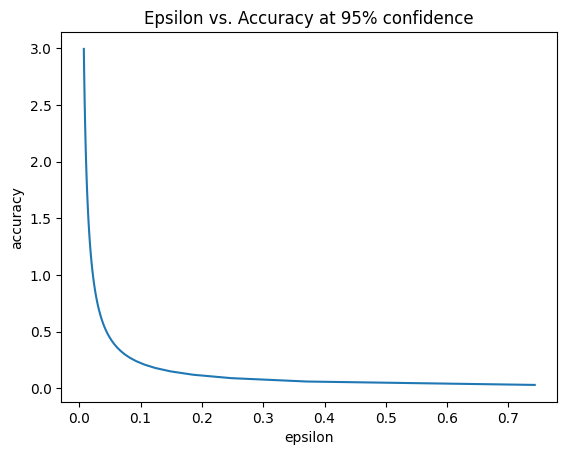

In [11]:
import matplotlib.pyplot as plt
import numpy as np

scales = np.linspace(0.01, 1., num=100)
epsilons = [make_mean_age(s).map(max_contributions) for s in scales]
accuracies = [dp.laplacian_scale_to_accuracy(scale=s, alpha=0.05) for s in scales]
plt.plot(epsilons, accuracies)
plt.title("Epsilon vs. Accuracy at 95% confidence")
plt.xlabel("epsilon")
plt.ylabel("accuracy");

When the privacy guarantees become looser, the confidence intervals for your estimate become tighter.
Your needs will determine the ideal tradeoff between privacy and utility.
The OpenDP Library provides methods that make this tradeoff as tight as possible.

Let's commit to a noise scale of 0.05.

In [12]:
mean_age_meas = make_mean_age(scale=0.05)

In [13]:
# what would the epsilon expenditure be, if the scale were 0.05?
mean_age_meas.map(d_in=max_contributions)

0.1485714285796542

In [14]:
# what would the accuracy be, if the scale were 0.05?
dp.laplacian_scale_to_accuracy(scale=0.05, alpha=0.05)

0.14978661367769955

When the Laplace distribution's scale is 0.05, the DP estimate will differ from the exact estimate by no more than 0.15, at a 95% confidence level.
This accuracy estimate doesn't include potential bias incurred by the preprocessing: in this case, the clamping (and resize) may bias the the exact estimate away from the true mean in a way that isn't characterized by this accuracy estimate.

## Composition

When you make multiple releases on the same dataset, the epsilons for each release "add up".

The total epsilon spend is the sum of the epsilon consumption of each measurement we make on the sensitive dataset.

In [15]:
count_meas.map(max_contributions) + mean_age_meas.map(max_contributions)

0.6485714285796542

With this release, the overall privacy expenditure will become $\epsilon = 0.65$.

In [16]:
mean_age_meas(csv_data)

37.4229953984929

The mean age of individuals in the sensitive dataset is 37.35.